In [1]:
#!python3 -m pip install matplotlib_venn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib_venn import venn2
from matplotlib.ticker import ScalarFormatter

In [2]:
#colors
sns.set_style("whitegrid")
bgi_main = '#5eaab3'
bgi_lght = '#aacfd5'
ill_main = '#ee7339'
shared_cl = '#94a577'
shared_cl2 = '#bfd1a1'
main_cl = '#1c4e9c'

In [3]:
def clean_microbiome_df(df, shared_samples, final_set):
    df = df.copy()
    # Filter out sp. with relative abundance < 0.001
    df[df < 0.001] = 0

    # Filter out all unclassified sp.
    df = df[~df.index.astype(str).str.startswith('bin')]

    # Keep only shared samples
    df = df[df.columns.intersection(shared_samples)]

    # Keep only samples from final set
    df = df[df.columns.intersection(final_set['sample_name'])]

    # Drop rows and columns that contain only zeros
    df = df.loc[~(df == 0).all(axis=1)]  
    df = df.loc[:, ~(df == 0).all(axis=0)]  

    return df

from numpy import mean
from numpy import var
from math import sqrt

def cohend(d1,d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s


## Read data

In [4]:
### Read Kraken data.Species level
path = '/Users/katerynapantiukh/Library/CloudStorage/OneDrive-TartuÜlikool/2023_Illumina_vs_BGI/kraken'

final_set = pd.read_csv('input/smpls_sets/final_samples_set_1351.txt')
# read kraken results
mgi_df = pd.read_csv(str(path) + "/Cross-Platform_set_results/BGI_final_abud_all.csv", sep=',', index_col=0)
mgi_df.columns = mgi_df.columns.str.replace('bgi_', '')
ill_df = pd.read_csv(str(path) + "/Cross-Platform_set_results/Illumina_final_abud_all.csv", sep=',', index_col=0)
ill_df.columns = ill_df.columns.str.replace('ill_', '')

# Select only shared samples
shared_samples = list(set(mgi_df.columns) & set(ill_df.columns))
print("Shared samples:", len(shared_samples))
        
mgi_df = clean_microbiome_df(mgi_df, shared_samples, final_set)
ill_df = clean_microbiome_df(ill_df, shared_samples, final_set)

print("MGI samples:", len(mgi_df.columns))
print("Illumina samples:", len(ill_df.columns), '\n')
print("MGI species:", len(mgi_df.index))
print("Illumina species:", len(ill_df.index))

mgi_df.head(2)

Shared samples: 1990
MGI samples: 1351
Illumina samples: 1351 

MGI species: 2867
Illumina species: 2865


,VNN89Q,VNIDA4,V4O7YS,VPEB3X,VAEQ34,VR8E19,V2VJWP,VMJVUD,V4OUOI,V06KFU,...,VW8KUI,VGYWXY,V86Z0W,VI7GET,VYYIUL,VC7BF0,VNJOCX,VNFOKA,VBSSCF,VE0WMY
name,,,,,,,,,,,,,,,,,,,,,
Phocaeicola plebeius_A,0.06195,0.00852,0.00243,0.00323,0.00131,0.02083,0.0,0.00778,0.00506,0.0,...,0.00655,0.0,0.00000,0.0,0.09912,0.01204,0.0,0.0,0.11206,0.0
Phocaeicola sp000432735,0.03978,0.00266,0.00000,0.00113,0.00000,0.00000,0.0,0.00000,0.00763,0.0,...,0.00000,0.0,0.01957,0.0,0.00123,0.00000,0.0,0.0,0.00963,0.0


In [5]:
all_sp = set(mgi_df.index) | set(ill_df.index)
print("All detected species: ", len(all_sp))
print("Species present in both MGI & NovaSeq set: ", len(set(mgi_df.index) & set(ill_df.index)))
print("Species present only in MGI set: ", len(set(mgi_df.index) - set(ill_df.index)))
print("Species present only in NovaSeq set: ", len(set(ill_df.index) - set(mgi_df.index)), '\n')
print(2953-2779)

unique1 = set(mgi_df.index) - set(ill_df.index)
unique2 = set(ill_df.index) - set(mgi_df.index)
uniqueT = set(unique1) | set(unique2)
print("Proportion of not shared species in MGI: ", len(uniqueT)/ len(all_sp) * 100, '\n')

All detected species:  2953
Species present in both MGI & NovaSeq set:  2779
Species present only in MGI set:  88
Species present only in NovaSeq set:  86 

174
Proportion of not shared species in MGI:  5.8923129021334235 



## Prev & abud

In [6]:
# calculate non zero columns per each raw mgi_df
mgi_prev = mgi_df.copy()
mgi_prev['prev_numb'] = (mgi_prev  != 0).sum(axis=1)
mgi_prev['prev_perc'] = mgi_prev['prev_numb'] / (len(mgi_prev.columns)-1) * 100
# mean per sample
mgi_ab = mgi_df.copy()
mgi_ab['mean_abud'] = mgi_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging
mgi_det = pd.merge(mgi_prev[['prev_numb', 'prev_perc']], mgi_ab[['mean_abud']], left_index=True, right_index=True)

ill_prev = ill_df.copy()
# calculate non zero columns per each raw ill_df
ill_prev['prev_numb'] = (ill_prev  != 0).sum(axis=1)
ill_prev['prev_perc'] = ill_prev['prev_numb'] / (len(ill_prev.columns)-1) * 100
# mean per sample
ill_ab = ill_df.copy()
ill_ab['mean_abud'] = ill_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging     
ill_det = pd.merge(ill_prev[['prev_numb', 'prev_perc']], ill_ab[['mean_abud']], left_index=True, right_index=True)

mrg = pd.merge(mgi_det, ill_det, left_index=True, right_index=True, suffixes=('_mgi', '_ill'))
mrg.head(2)

,prev_numb_mgi,prev_perc_mgi,mean_abud_mgi,prev_numb_ill,prev_perc_ill,mean_abud_ill
name,,,,,,
Phocaeicola plebeius_A,589,43.597335,0.012352,583,43.153220,0.012044
Phocaeicola sp000432735,250,18.504811,0.003211,247,18.282754,0.003121


In [12]:
usp1 = mgi_det[mgi_det.index.isin(unique1)]
ssp1 = mgi_det[~mgi_det.index.isin(unique1)]
usp1 = usp1.copy()
usp1['platform'] = 'MGI'

usp2 = ill_det[ill_det.index.isin(unique2)].copy()
ssp2 = ill_det[~ill_det.index.isin(unique1)]
usp2['platform'] = 'NovaSeq'

usp = pd.concat([usp1, usp2])
ssp = pd.concat([ssp1, ssp2])
usp.to_excel('results/platform-specific_sp.xlsx')

print("Mean abud, set-specific species: ",usp['mean_abud'].mean())
print("Mean abud, shared species: ",ssp['mean_abud'].mean())

Mean abud, set-specific species:  1.307375549826863e-06
Mean abud, shared species:  0.00028300486528340027


In [14]:
usp['prev_numb'].value_counts()

1     154
2      14
3       3
21      1
4       1
12      1
Name: prev_numb, dtype: int64

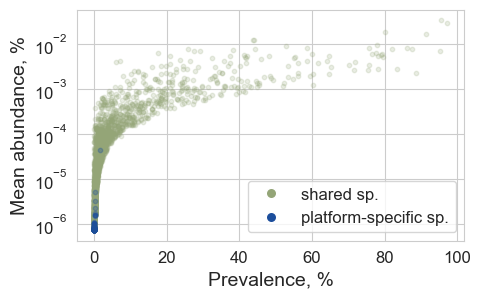

In [17]:
# assign status to mgi_det, based on the presence of species in unique1
mgi_det['status'] = np.where(mgi_det.index.isin(unique1), 'unique', 'shared')
# assign status to ill_det, based on the presence of species in unique2
ill_det['status'] = np.where(ill_det.index.isin(unique2), 'unique', 'shared')

# Map colors to the 'status' column
color_map = {'unique': 'red', 'shared': 'blue'}
colors = mgi_det['status'].map(color_map)

# Create the scatter plot
sh = mgi_det[mgi_det['status'] == 'shared']
un = mgi_det[mgi_det['status'] == 'unique']

plt.figure(figsize=(5,3))
plt.scatter(sh['prev_perc'], sh['mean_abud'], alpha=0.2, c=shared_cl, s=10)
plt.scatter(un['prev_perc'], un['mean_abud'], alpha=0.3, c=main_cl, s=10)
plt.xlabel('Prevalence, %', fontsize=14)
plt.ylabel('Mean abundance, %', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# log scale
plt.yscale('log')
# Create custom legend handles
from matplotlib.lines import Line2D
legend_elements = [
	Line2D([0], [0], marker='o', color='w', label='shared sp.', markerfacecolor=shared_cl, markersize=5),
	Line2D([0], [0], marker='o', color='w', label='platform-specific sp.', markerfacecolor=main_cl, markersize=5)
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='lower right', fontsize=12, markerscale=1.5)

plt.savefig("results/Figure_4/Fig4b.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4b.svg", bbox_inches='tight')

plt.show()

In [11]:
# Calculate the number of species for MGI and NovaSeq using vectorized operations
mgi_vals = (mgi_df > 0).sum(axis=0)
ill_vals = (ill_df > 0).sum(axis=0)

sp_numb = pd.DataFrame({'MGI': mgi_vals, 'NovaSeq': ill_vals})
print("MGI mean species per sample: ", sp_numb['MGI'].mean().round(1))
print("NovaSeq mean species per sample: ", sp_numb['NovaSeq'].mean().round(1))
sp_numb.head(2)


MGI mean species per sample:  124.3
NovaSeq mean species per sample:  124.8


,MGI,NovaSeq
V00H9L,123,127
V010T4,139,140


## Higher level taxa

In [12]:
# Genus
mgi_gen = pd.read_excel(str(path) + "/Cross-Platform_set_aggregation/genus_BGI_abud_part1.xlsx", index_col=0)
mgi_gen.columns = mgi_gen.columns.str.replace('bgi_', '')
ill_gen = pd.read_excel(str(path) + "/Cross-Platform_set_aggregation/genus_Illumina_abud_part1.xlsx", index_col=0)
ill_gen.columns = ill_gen.columns.str.replace('ill_', '')
# Families
mgi_fam = pd.read_excel(str(path) + "/Cross-Platform_set_aggregation/Family_BGI_abud_part1.xlsx", index_col=0)
mgi_fam.columns = mgi_fam.columns.str.replace('bgi_', '')
ill_fam = pd.read_excel(str(path) + "/Cross-Platform_set_aggregation/Family_Illumina_abud_part1.xlsx", index_col=0)
ill_fam.columns = ill_fam.columns.str.replace('ill_', '')

mgi_gen = clean_microbiome_df(mgi_gen, shared_samples, final_set)
ill_gen = clean_microbiome_df(ill_gen, shared_samples, final_set)
mgi_fam = clean_microbiome_df(mgi_fam, shared_samples, final_set)
ill_fam = clean_microbiome_df(ill_fam, shared_samples, final_set)

gen = pd.DataFrame(columns=['MGI', 'NovaSeq'])
gen1 = mgi_df.index.str.split(" ").str.get(0).drop_duplicates()
gen2 = ill_df.index.str.split(" ").str.get(0).drop_duplicates()

print("All detected genera: ", len(set(gen1) | set(gen2)))
print("Genera present in both MGI & NovaSeq set: ", len(set(gen1) & set(gen2)))
print("Genera present only in MGI set: ", len(set(gen1) - set(gen2)))
print("Genera present only in NovaSeq set: ", len(set(gen2) - set(gen1)))

All detected genera:  808
Genera present in both MGI & NovaSeq set:  771
Genera present only in MGI set:  14
Genera present only in NovaSeq set:  23


In [13]:
# Genus number
mgi_gen_vals = (mgi_gen > 0).sum(axis=0)
ill_gen_vals = (ill_gen > 0).sum(axis=0)
gen_numb = pd.DataFrame({'MGI': mgi_gen_vals, 'NovaSeq': ill_gen_vals})
gen_numb.head(2)

,MGI,NovaSeq
V00H9L,12,12
V010T4,14,12


In [14]:
# Family number
mgi_fam_vals = (mgi_fam > 0).sum(axis=0)
ill_fam_vals = (ill_fam > 0).sum(axis=0)

fam_numb = pd.DataFrame({'MGI': mgi_fam_vals, 'NovaSeq': ill_fam_vals})
fam_numb.head(2)

,MGI,NovaSeq
V00H9L,8,8
V010T4,10,9


## Analysis & Plots

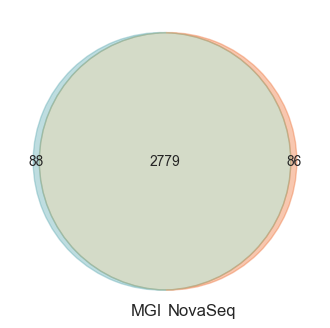

In [15]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Create a Venn diagram
plt.figure(figsize=(4, 4))
venn = venn2(subsets=(set(mgi_df.index), set(ill_df.index)),
             set_labels=('MGI', 'NovaSeq'))
venn.get_patch_by_id('10').set_color(bgi_main)
venn.get_patch_by_id('01').set_color(ill_main)
venn.get_patch_by_id('11').set_color(shared_cl)

plt.savefig("results/Figure_4/Fig4a.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4a.svg", bbox_inches='tight')

plt.show()

### Species

In [38]:
# Calculate deltas (differences between paired samples)
sp_numb['delta'] = sp_numb['MGI'] - sp_numb['NovaSeq']

# Test normality
from scipy.stats import shapiro
shapiro(sp_numb['delta'])

from scipy.stats import wilcoxon
stat, p = wilcoxon(sp_numb['MGI'], sp_numb['NovaSeq'])
#print("Wilcoxon test statistic:", stat)
if p<0.05:
    print("Nope, it's significantly not normal, p-value:", p)
    # OR Wilcoxon test
    from scipy.stats import wilcoxon
    stat, p_val = wilcoxon(sp_numb['MGI'], sp_numb['NovaSeq'])
    print("Paired wilcoxon p-value:", p_val)
else:
    print("It is normal, p-value:", p)
    # Paired t-test
    from scipy.stats import ttest_rel
    t_stat, p_val = ttest_rel(sp_numb['MGI'], sp_numb['NovaSeq'])
    print("Paired t-test p-value:", p_val)

#Quantify Effect Size
print("absolute difference between two means ", (sp_numb['MGI'].mean() - sp_numb['NovaSeq'].mean()).round(2))

cohend(sp_numb['MGI'],sp_numb['NovaSeq'])
print("Cohen's d ≈ ", cohend(sp_numb['MGI'],sp_numb['NovaSeq']).round(2))

Nope, it's significantly not normal, p-value: 1.0365915000426145e-07
Paired wilcoxon p-value: 1.0365915000426145e-07
absolute difference between two means  -0.5
Cohen's d ≈  -0.02


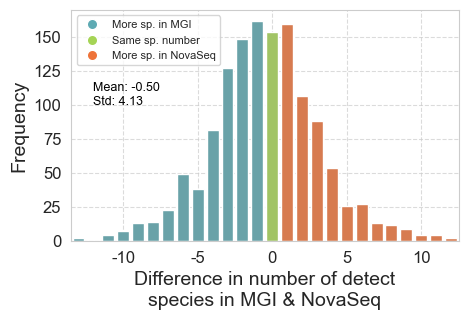

In [17]:
# plot the diferences
cnts = sp_numb['delta'].value_counts().to_frame()
cnts = cnts.reindex(range(-13, 13), fill_value=0)
cnts = cnts.reset_index()  
cnts = cnts.sort_values(by='index')

colors = []
for val in range(-13, 14):
    if val < 0:
        colors.append(bgi_main)  
    elif val == 0:
        colors.append("#a5d455")     
    else:
        colors.append(ill_main)  
        
# 3. Plot the boxplot
plt.figure(figsize=(5, 3))
ax = sns.barplot(x='index', y='delta', data=cnts, palette=colors)

# Define which ticks to show
ticks_to_show = [-10, -5, 0, 5, 10]
tick_positions = [cnts[cnts['index'] == val].index[0] for val in ticks_to_show if val in cnts['index'].values]
ax.set_xticks(tick_positions)
ax.set_xticklabels([str(t) for t in ticks_to_show])

plt.xlabel('Difference in number of detect\nspecies in MGI & NovaSeq', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(-13, 13)
plt.text(1, 100, f'Mean: {np.mean(sp_numb["delta"]):.2f}\nStd: {np.std(sp_numb["delta"]):.2f}', fontsize=9, color='black')

# Create custom legend handles
from matplotlib.lines import Line2D
legend_elements = [
	Line2D([0], [0], marker='o', color='w', label='More sp. in MGI', markerfacecolor=bgi_main, markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Same sp. number', markerfacecolor="#a5d455", markersize=5),
	Line2D([0], [0], marker='o', color='w', label='More sp. in NovaSeq', markerfacecolor=ill_main, markersize=5)
]

# Add the custom legend
plt.legend(handles=legend_elements, loc='upper left', fontsize=8, markerscale=1.5)
plt.grid(linestyle='--', alpha=0.7)

plt.savefig("results/Figure_4/Fig4c.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4c.svg", bbox_inches='tight')

plt.show()


Paired t-test statistic: -4.4414451015954555
Paired t-test p-value: 9.665290404953204e-06


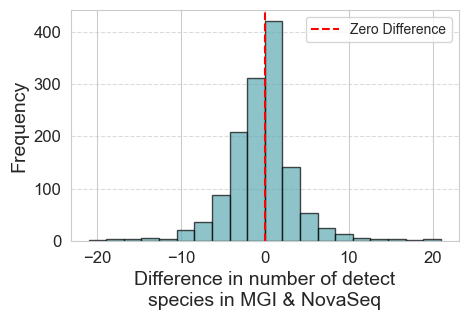

In [18]:
# calculate paired t-test
from scipy import stats
t_stat, p_val = stats.ttest_rel(sp_numb['MGI'], sp_numb['NovaSeq'])
print("Paired t-test statistic:", t_stat)
print("Paired t-test p-value:", p_val)

# Calculate deltas (differences between paired samples)
sp_numb['delta'] = sp_numb['MGI'] - sp_numb['NovaSeq']

# Plot the distribution of deltas
plt.figure(figsize=(5,3))
plt.hist(sp_numb['delta'], bins=20, color=bgi_main, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference in number of detect\nspecies in MGI & NovaSeq', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

#plt.savefig("results/Figure_4/Fig4c.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_4/Fig4c.svg", bbox_inches='tight')

plt.show()


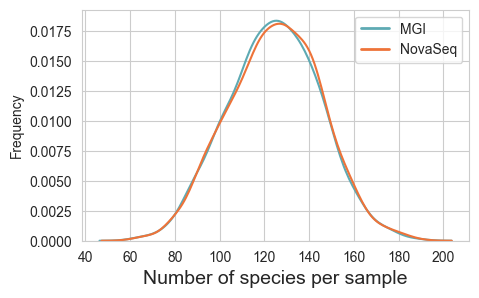

In [19]:
from matplotlib.lines import Line2D

plt.figure(figsize=(5,3))
sns.set_style('whitegrid')
sns.kdeplot(sp_numb, x="MGI", color=bgi_main)
sns.kdeplot(sp_numb, x="NovaSeq", color=ill_main, linestyle='-')

plt.xlabel("Number of species per sample", fontsize=14)
plt.ylabel("Frequency")
# Custom legend handles
legend_elements = [
    Line2D([0], [0], color=bgi_main, lw=2, linestyle='-', label='MGI'),
    Line2D([0], [0], color=ill_main, lw=2, linestyle='-', label='NovaSeq')
]

# Add the custom legend
plt.legend(handles=legend_elements)

plt.savefig("results/Figure_4/Suppl-1.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_4/Suppl-1.svg", bbox_inches='tight')

plt.show()

### Genus

Paired t-test statistic: -2.716938303157933
Paired t-test p-value: 0.006673083871703894


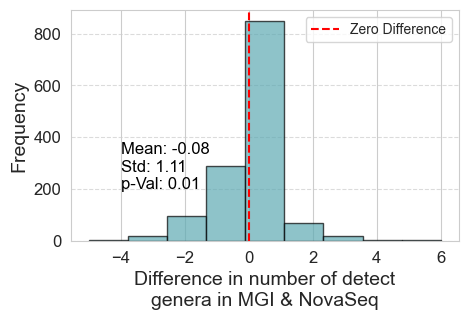

In [20]:
# calculate paired t-test
from scipy import stats
t_stat, p_val = stats.ttest_rel(gen_numb['MGI'], gen_numb['NovaSeq'])
print("Paired t-test statistic:", t_stat)
print("Paired t-test p-value:", p_val)

# Calculate deltas (differences between paired samples)
gen_numb['delta'] = gen_numb['MGI'] - gen_numb['NovaSeq']

# Plot the distribution of deltas
plt.figure(figsize=(5,3))
plt.hist(gen_numb['delta'], bins=9, color=bgi_main, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference in number of detect\ngenera in MGI & NovaSeq', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(-5, 5)
plt.text(-4, 200, f'Mean: {np.mean(gen_numb["delta"]):.2f}\nStd: {np.std(gen_numb["delta"]):.2f}\np-Val: {p_val:.2f}', fontsize=12, color='black')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("results/Figure_4/Suppl-4.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_4/Suppl-4.svg", bbox_inches='tight')

plt.show()


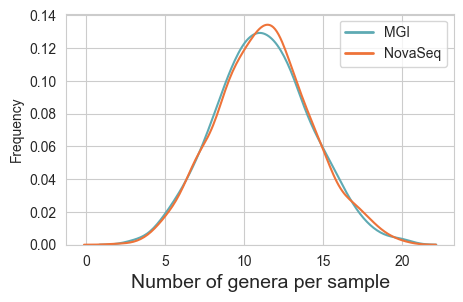

In [21]:
from matplotlib.lines import Line2D

plt.figure(figsize=(5,3))
sns.set_style('whitegrid')
sns.kdeplot(gen_numb, x="MGI", color=bgi_main)
sns.kdeplot(gen_numb, x="NovaSeq", color=ill_main, linestyle='-')
#plt.yscale("log")
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("Number of genera per sample", fontsize=14)
plt.ylabel("Frequency")
# Custom legend handles
legend_elements = [
    Line2D([0], [0], color=bgi_main, lw=2, linestyle='-', label='MGI'),
    Line2D([0], [0], color=ill_main, lw=2, linestyle='-', label='NovaSeq')
]

# Add the custom legend
plt.legend(handles=legend_elements)

plt.savefig("results/Figure_2/Suppl-3.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_2/Suppl-3.svg", bbox_inches='tight')

plt.show()

## Families

Paired t-test statistic: -2.5947274065349144
Paired t-test p-value: 0.009569154111051921


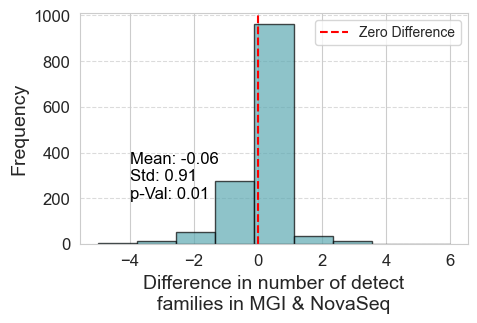

In [22]:
# calculate paired t-test
from scipy import stats
t_stat, p_val = stats.ttest_rel(fam_numb['MGI'], fam_numb['NovaSeq'])
print("Paired t-test statistic:", t_stat)
print("Paired t-test p-value:", p_val)

# Calculate deltas (differences between paired samples)
fam_numb['delta'] = fam_numb['MGI'] - fam_numb['NovaSeq']

# Plot the distribution of deltas
plt.figure(figsize=(5,3))
plt.hist(fam_numb['delta'], bins=9, color=bgi_main, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Difference')
plt.xlabel('Difference in number of detect\nfamilies in MGI & NovaSeq', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(-13, 13)
plt.text(-4, 200, f'Mean: {np.mean(fam_numb["delta"]):.2f}\nStd: {np.std(fam_numb["delta"]):.2f}\np-Val: {p_val:.2f}', fontsize=12, color='black')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("results/Figure_4/Suppl-4.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_4/Suppl-4.svg", bbox_inches='tight')

plt.show()


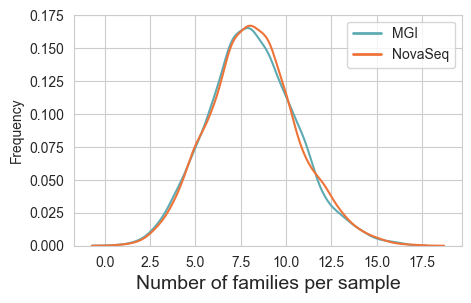

In [23]:
from matplotlib.lines import Line2D

plt.figure(figsize=(5,3))
sns.set_style('whitegrid')
sns.kdeplot(fam_numb, x="MGI", color=bgi_main)
sns.kdeplot(fam_numb, x="NovaSeq", color=ill_main, linestyle='-')
#plt.yscale("log")
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("Number of families per sample", fontsize=14)
plt.ylabel("Frequency")
# Custom legend handles
legend_elements = [
    Line2D([0], [0], color=bgi_main, lw=2, linestyle='-', label='MGI'),
    Line2D([0], [0], color=ill_main, lw=2, linestyle='-', label='NovaSeq')
]

# Add the custom legend
plt.legend(handles=legend_elements)

plt.savefig("results/Figure_4/Suppl-5.png", dpi=300, bbox_inches='tight')
#plt.savefig("results/Figure_4/Suppl-5.svg", bbox_inches='tight')

plt.show()

## Share percentage

In [24]:
shared_sp = pd.read_excel('input/shared_species_NovaSeq-MGI.xlsx')
shared_sp = shared_sp[shared_sp['sample'].isin(final_set['sample_name'])]
print('Numer of smpls in file:', len(shared_sp))
shared_sp.head(2)

Numer of smpls in file: 1351


,bgi,shared,ill,sample,bottom,bgi_counts,ill_counts,shared_counts,sample_no,type
0,0.0,1.0,0.0,V5NIUH,1.0,0,0,89,1,NaN
1,0.0,1.0,0.0,V9Y37D,1.0,0,0,103,2,NaN


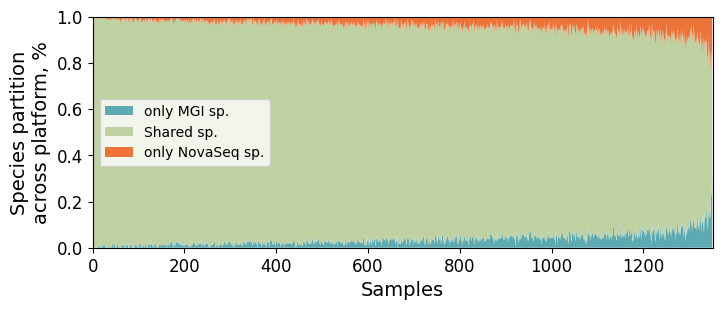

In [25]:
# read the data
plt.figure(figsize=(8,3))
sns.set_style('white')
sns.reset_defaults()
plt.stackplot(shared_sp.index, shared_sp.bgi, shared_sp.shared, shared_sp.ill, labels=['only MGI sp.', 'Shared sp.','only NovaSeq sp.'], colors=[bgi_main, shared_cl2, ill_main], alpha = 1)
plt.legend(loc='center left') #bbox_to_anchor=(1.1, 1.0))
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Species partition\nacross platform, %", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,1351])
plt.ylim([0,1])

plt.savefig("results/Figure_4/Fig4d.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4d.svg", bbox_inches='tight')

plt.show()

92.0794848485542
5.204703995011331


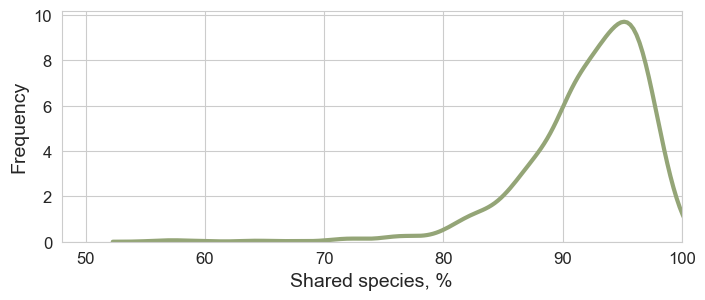

In [26]:
plt.figure(figsize=(8,3))
sns.set_style("whitegrid")

sns.kdeplot(list(shared_sp.sort_values(by='shared', ascending=True)['shared']), color=shared_cl, linewidth=3) 
plt.grid()
#plt.title("Distribution of the fraction of shared species")
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Shared species, %", fontsize=14)
plt.xlim(0.48, 1)
plt.xticks([0.5,0.6,0.7,0.8,0.9,1],labels=[50,60,70,80,90,100], fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().invert_xaxis()
plt.grid()

print(shared_sp['shared'].mean()*100)
print(shared_sp['shared'].std()*100)

plt.savefig("results/Figure_4/Fig4e.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4e.svg", bbox_inches='tight')

plt.show()

## Prevalence & rel. abundance

In [27]:
# calculate non zero columns per each raw mgi_df
mgi_prev = mgi_df.copy()
mgi_prev['prev_numb'] = (mgi_prev  != 0).sum(axis=1)
mgi_prev['prev_perc'] = mgi_prev['prev_numb'] / (len(mgi_prev.columns)-1) * 100
# mean per sample
mgi_ab = mgi_df.copy()
mgi_ab['mean_abud'] = mgi_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging
mgi_det = pd.merge(mgi_prev[['prev_numb', 'prev_perc']], mgi_ab[['mean_abud']], left_index=True, right_index=True)

ill_prev = ill_df.copy()
# calculate non zero columns per each raw ill_df
ill_prev['prev_numb'] = (ill_prev  != 0).sum(axis=1)
ill_prev['prev_perc'] = ill_prev['prev_numb'] / (len(ill_prev.columns)-1) * 100
# mean per sample
ill_ab = ill_df.copy()
ill_ab['mean_abud'] = ill_ab.mean(axis=1)
# Ensure both DataFrames have the same index before merging     
ill_det = pd.merge(ill_prev[['prev_numb', 'prev_perc']], ill_ab[['mean_abud']], left_index=True, right_index=True)

mrg = pd.merge(mgi_det, ill_det, left_index=True, right_index=True, suffixes=('_mgi', '_ill'))
mrg.head(2)


,prev_numb_mgi,prev_perc_mgi,mean_abud_mgi,prev_numb_ill,prev_perc_ill,mean_abud_ill
name,,,,,,
Phocaeicola plebeius_A,589,43.597335,0.012352,583,43.153220,0.012044
Phocaeicola sp000432735,250,18.504811,0.003211,247,18.282754,0.003121


R^2: 0.9999965783622154


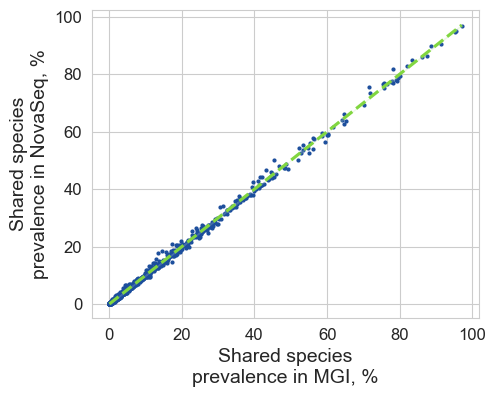

In [28]:
# Scatter plot and regression line
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
plt.figure(figsize=(5, 4))

plt.scatter(mrg['prev_perc_mgi'], mrg['prev_perc_ill'], s=4, color=main_cl)
plt.grid()

# Fitting the linear regression model to calculate residuals
X = mrg['prev_perc_mgi'].values.reshape(-1, 1)
y = mrg['prev_perc_ill'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(X, y_pred)
print("R^2:", r2)
# Calculate residuals
residuals = y - y_pred

# Add regression line
sns.regplot(x=mrg['prev_perc_mgi'], y=mrg['prev_perc_ill'], scatter=False, line_kws={"color": "#81d640", "linestyle": "--"})
plt.ylabel("Shared species\nprevalence in NovaSeq, %", fontsize=14)
plt.xlabel("Shared species\nprevalence in MGI, %", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.text(0.1, 0.9, f'$R^2$ = {r2:.3f}', fontsize=12, color='black', transform=plt.gca().transAxes)
plt.grid()
plt.savefig("results/Figure_4/Fig4f.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4f.svg", bbox_inches='tight')

plt.show()

Pearsons correlation: 0.999
R^2: 0.9999786878655167


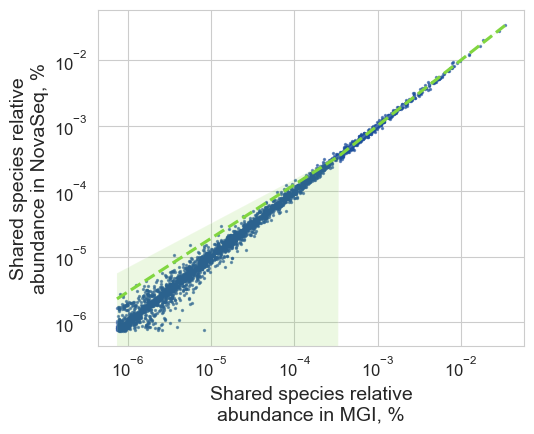

In [33]:
from scipy.stats import pearsonr
corr, _ = pearsonr(mrg['mean_abud_mgi'], mrg['mean_abud_ill'])
print('Pearsons correlation: %.3f' % corr)

plt.figure(figsize=(5,4))

# Smooth scatter (KDE) and scatter plot combined
plt.scatter(mrg['mean_abud_mgi'], mrg['mean_abud_ill'], s=2, color=main_cl, alpha=0.6)
plt.grid()
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#residuals_clipped = np.clip(residuals, a_min=1e-5, a_max=None)
plt.tight_layout()

# Fitting the linear regression model to calculate residuals
X = mrg['mean_abud_mgi'].values.reshape(-1, 1)
y = mrg['mean_abud_ill'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(X, y_pred)
print("R^2:", r2)
# Calculate residuals
residuals = y - y_pred

# Add regression line
sns.regplot(x=mrg['mean_abud_mgi'], y=mrg['mean_abud_ill'], scatter=False, line_kws={"color": "#81d640", "linestyle": "--"})
plt.grid()
plt.xlabel("Shared species relative\nabundance in MGI, %", fontsize=14)
plt.ylabel("Shared species relative\nabundance in NovaSeq, %", fontsize=14)

plt.savefig("results/Figure_4/Fig4g.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4g.svg", bbox_inches='tight')

plt.show()

# Shannon Idx

In [30]:
# calculate shannon
from skbio.diversity.alpha import shannon, simpson

alpha1 = mgi_df.T.apply(shannon, axis=1)
alpha1 = pd.DataFrame(alpha1)
alpha1.columns = ['shannon']
alpha1['Sequencing'] = 'MGI'

alpha2 = ill_df.T.apply(shannon, axis=1)
alpha2 = pd.DataFrame(alpha2)
alpha2.columns = ['shannon']
alpha2['Sequencing'] = 'NovaSeq'

alpha = pd.concat([alpha1, alpha2], axis=0)
alpha = alpha.reset_index()
print(len(alpha))
alpha.head(2)

2702


/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,index,shannon,Sequencing
0,VNN89Q,4.016044,MGI
1,VNIDA4,4.346931,MGI


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MGI v.s. NovaSeq: t-test paired samples with Bonferroni correction, P_val=4.522e-01 stat=-7.520e-01


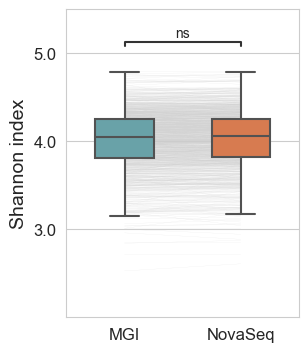

In [31]:
#%pip install statannot
from statannot import add_stat_annotation

pairs = [('MGI', 'NovaSeq')]  # Correct group names

plt.figure(figsize=(3, 4))
ax = plt.gca()

# 1. Draw grey lines connecting the pairs first (so they're underneath the boxes)
if "index" in alpha.columns:
    for sample_id, group in alpha.groupby("index"):
        if group.shape[0] == 2:
            x_vals = [0, 1] if group.iloc[0]["Sequencing"] == "MGI" else [1, 0]
            y_vals = group.sort_values("Sequencing")["shannon"].values
            ax.plot(x_vals, y_vals, color='lightgrey', linewidth=0.1, alpha=0.7, zorder=0)  # zorder=1 ensures background

# 2. Draw the boxplot after (so it's on top)
sns.boxplot(data=alpha, x="Sequencing", y="shannon", zorder=1,
            fliersize=0, palette=[bgi_main, ill_main], width=0.5, ax=ax)

plt.ylabel("Shannon index", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([3, 4, 5], labels=[3.0, 4.0, 5.0], fontsize=12)

# Add statistical annotations
add_stat_annotation(ax, data=alpha, x="Sequencing", y="shannon",
                    box_pairs=pairs,
                    test='t-test_paired',
                    text_format='star',  
                    loc='outside', verbose=2)

plt.ylim([2, 5.5])
plt.xlabel("")
plt.savefig("results/Figure_4/Fig4h.png", dpi=300, bbox_inches='tight')
plt.savefig("results/Figure_4/Fig4h.svg", bbox_inches='tight')
plt.show()


## Calculate shared fraction if needed

In [32]:
# shared_fraction
mgi1_only = []
mgi2_only = []
shared = []
x_names = []
bottom_list = []

for a in shared_samples:
    try:
        sample_mgi1_only = 0
        sample_mgi2_only = 0
        sample_shared = 0

        in_mgi1 = list(mgi1_df.loc[mgi1_df[a] > 0].index)
        in_mgi2 = list(mgi2_df.loc[mgi2_df[a] > 0].index)
        all_found = list(set(in_mgi1 + in_mgi2))
        for b in all_found:
            if b in in_mgi1 and b not in in_mgi2:
                sample_mgi1_only += 1
            elif b not in in_mgi1 and b in in_mgi2:
                sample_mgi2_only += 1
            elif b in in_mgi1 and b in in_mgi2:
                sample_shared += 1
        mgi1_only.append(100*sample_mgi1_only/len(all_found))
        mgi2_only.append(100*sample_mgi2_only/len(all_found))
        shared.append(100*sample_shared/len(all_found))
        bottom_list.append(100*sample_mgi1_only/len(all_found) + 100*sample_shared/len(all_found))
        x_names.append(a)
    except:
        print(a)

stacked_df = pd.DataFrame(columns = ['mgi1','shared','mgi2','sample','bottom'])
stacked_df['mgi1'] = mgi1_only
stacked_df['mgi2'] = mgi2_only
stacked_df['shared'] = shared
stacked_df['sample'] = x_names
stacked_df['bottom'] = bottom_list
stacked_df = stacked_df.sort_values(by="shared", ascending=False).reset_index()

stacked_df.to_excel('input/shared_species_MGI-MGI.xlsx', index=False)


VNWDAJ
VWZEWE
V7OJZJ
VXZTBT
VW29UH
VF48GR
V7S9L3
VEOK8R
VBPRL4
V8X023
V9TITB
VP5ZAB
VVOBA0
VB1FWX
VNQX61
V8RU1D
VM10DN
V3MK5S
VCFFJJ
VMY7BP
VM901L
VH1QJ7
VJTG9V
V3U9VV
VEQ5KC
VVHM1U
V2GRUA
V8Q521
VTFFPJ
VO99M5
V4KZ09
V47GD0
V5PYEC
VVAE9L
VS5OEG
VC8QHS
V0YSOI
V6G6IG
V88BZU
V9GZZQ
VTARO6
VAERO7
VM9PPT
V8PAF4
V7QAH0
VRQ166
VHVY0M
VSHD6H
VX6G26
VU0WT9
V8F17Q
VI4E6Q
VOA27A
V4BF1X
V3V8M0
VGHLVX
VOGJHG
VS9EPY
V1TT57
VHATLP
VKUW8T
VJZ9UB
VOFI2M
VLPANX
VFT4Q5
VY1MGO
VNQ5GI
V96VVO
VHEX54
V22M5I
VDZJH4
VQWUQN
VAPK0E
VPT3AV
V4S8AO
VTSBVR
V4IZWO
VH7JT3
VJ2UBT
VIQZMD
VAT7LH
VYVFO8
VTTYB4
V4J3DG
VQWTOE
VMJIGS
VSH6RW
VORW0X
VZ1AH2
V9SW05
V87R7C
VUR0YN
VFZRX0
VXAIBG
VT2F0R
VQEB4Q
VSWSNY
V6SF50
VISPPX
VDI7FO
VXI644
VC7WS4
VFPGHQ
V5FT1E
V840ET
VZGZLV
VCEMYL
VLEGC4
V67RSJ
VMXJOJ
V8M1K2
V1FYCG
V20PN5
VXF8T3
V0RG9C
V14WFH
VQI6N0
VIJ2FQ
VQD73F
V9T3WX
VM0DLN
VODRSB
VGZMGK
VC4LMF
V887SA
VAJUNN
VZQYWY
V944TO
VR1JOR
VEU81T
VJAZQJ
VB8SBT
VKVIWT
V1WZON
VCGY6Q
VQ6PWW
VNGHHG
VVYRCJ
V8RHG3
VX2W7U
VYAI5J
VSNAX3
V2ZR8J